**MONTECARLO MODEL for STOCK PREDICTION**

Libraries to import

In [13]:
##Generic library for Array and Data-time format
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame

##Generic library to create plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

##Generic library to retrieve stock-Data
import yfinance as yf
from joblib import Parallel, delayed


In [3]:
##Return the yfinance.Ticker object that stores all the relevant stock informations
import warnings

##Return the DATA INFORMATIONS
def month_year():
    now = dt.datetime.now()
    return now.day, now.month, now.year

def get_stock_data(isin_string):
    try:
        stock_ticker = isin_string
        stock_data = yf.Ticker(stock_ticker)
        stock_info = stock_data.info  # Effettua una richiesta per ottenere le informazioni
        return stock_data
    except ValueError as e:
        print(f"Errore nel recuperare i dati per {isin_string}: {e}")
        return None
    except Exception as e:
        print(f"Si è verificato un errore non previsto per {isin_string}: {e}")
        return None



##Return the hystorical data with date expressed as string --> Suitable for calculations
def get_stock_with_date_index_data(
    stock_data, category, start_date, end_date
) -> DataFrame | DataFrame:
    full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")
    try:
        if isinstance(stock_data, yf.Ticker):
            hist_data = stock_data.history(start=start_date, end=end_date)
            hist_data.index = hist_data.index.strftime("%Y-%m-%d")
            hist_data = hist_data.reindex(full_date_range.strftime("%Y-%m-%d"))
            hist_data.infer_objects().ffill(inplace=True)

            hist_data_to_return = pd.DataFrame(
                index=full_date_range.strftime("%Y-%m-%d"),
                columns=["symbol","category","stock_price", "volume"],
            )
            hist_data_to_return["stock_price"] = hist_data["Close"]
            hist_data_to_return["volume"] = hist_data["Volume"]
            hist_data_to_return["category"] = category
            hist_data_to_return["symbol"] = stock_data.ticker
            
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', FutureWarning)
                hist_data_to_return.ffill(inplace=True)
            return hist_data_to_return
        else:
            raise ValueError(f"stock_data must be a yf.Ticker object, got {type(stock_data)} instead.")
    except Exception as e:
        print(f"Error: {e}")
        hist_data_to_return = pd.DataFrame(
            index=full_date_range.strftime("%Y-%m-%d"),
            columns=["symbol","stock_price", "volume"],
        )
        return hist_data_to_return

This Montecarlo Model is built based on the definition of **daily logarithmic return (dlr)** as function of the **drift** and **volatility** :

$$
dlr = ln \frac{price\_today}{price\_yesterday} \rightarrow price\_today = \exp{(dlr)} * price\_yesterday 
$$

$$
drift \sim mean(dlr) - \frac{\hat{V}(dlr)}{2}   
$$ 

$$
volatility \sim \sigma(dlr) * Z 
$$

$$
dlr = drift + volatility
$$

Where **Z** is coming from a chosen random distribution (i.e. normal, uniform)

Here, we start to retrieve data from the ticker that we are interested.

In [6]:
### GENERIC INFORMATION ABOUT stock and its HYSTORICAL BEHAVIOR
# Time Informations
day, month, year = month_year()

##stock_under_test = input("Enter the stock ticker symbol: ")
##start_date = input("Enter the start date (YYYY-MM-DD): ")
##category = input("Insert Category ETF, Crypto, Stock")

stock_under_test = "FWRA.L"
start_date = "2023-10-06"
category = "ETF"
usd_to_eur_conversion = "YES"

forex_change = "USDEUR=X"


#end_date = "2024-10-21"

end_date = f"{year}-{month}-{day}"
# 
stock_data_object = get_stock_data(stock_under_test)
stock_dataFrame   = get_stock_with_date_index_data(stock_data=stock_data_object,category=category,start_date=start_date,end_date=end_date)

forex_data_object = get_stock_data(forex_change)
forex_dataFrame   = get_stock_with_date_index_data(stock_data=forex_data_object,category="forex",start_date=start_date,end_date=end_date)


if usd_to_eur_conversion == "YES" : 
    stock_prices = stock_dataFrame["stock_price"] * forex_dataFrame["stock_price"] 
    print(f"Last Stock Price : € {stock_prices.iloc[-1]}")
else : 
    stock_prices = stock_dataFrame["stock_price"]
    print(f"Last Stock Price : $ {stock_prices.iloc[-1]}")
    
#stock_volumes    = stock_dataFrame["volume"]
#Last value of the Ticker

#print(f"Last Stock Volume : {stock_volumes.iloc[-1]}")

Last Stock Price : € 6.688235338338757


In [7]:
## Daily Logarithmic Return

logret      = np.log(stock_prices/stock_prices.shift(1))


#logvol      = np.log(stock_volumes/stock_volumes.shift(1))

## Drift and Volatility
number_simulation = 10**8

uniform_or_normal = "normal"

if uniform_or_normal == "uniform":
    Z           = np.random.uniform(-1,+1,number_simulation)
    est_error   = np.std(logret)/np.sqrt(number_simulation)
    #est_error_vol = np.std(logvol)/np.sqrt(number_simulation)
else:
    Z           = np.random.normal(0,1,(number_simulation)) 
    est_error   = 3*np.std(logret)/np.sqrt(number_simulation)
    #est_error_vol = 3*np.std(logvol)/np.sqrt(number_simulation)

drift       = np.mean(logret) - np.var(logret)/2
volatility  = np.std(logret) * Z 

#drift_vol       = np.mean(logvol) - np.var(logvol)/2
#volatility_vol  = np.std(logvol) * Z 

print(f"Logret with stock_prices {logret}")
#print(f"Logret with stock_prices_pct {logret_pct}")

print(f"With {uniform_or_normal} distribution , your error is : {est_error}")
#print(f"With {uniform_or_normal} distribution , your volume error is : {est_error_vol}")

Logret with stock_prices 2023-10-06         NaN
2023-10-07    0.000000
2023-10-08    0.000000
2023-10-09    0.000714
2023-10-10    0.017912
                ...   
2025-02-26    0.005698
2025-02-27   -0.006254
2025-02-28   -0.003182
2025-03-01    0.000000
2025-03-02    0.000000
Name: stock_price, Length: 514, dtype: float64
With normal distribution , your error is : 1.9709000372125727e-06


In [8]:
## Today Price calculation

today_price = stock_prices.iloc[-1] * np.exp(drift+volatility)

#today_volume = stock_volumes.iloc[-1] * np.exp(drift_vol+volatility_vol)

df_today_price = pd.DataFrame(today_price)

#df_today_volume = pd.DataFrame(today_volume)

#df_today_price.plot(title=f"{stock_under_test} Montecarlo Prediction",ylabel="Stock Price $",xlabel="Frequency",figsize=(20,10),legend=None)
#df_today_volume.plot(title=f"{stock_under_test} Montecarlo Volume Prediction",ylabel="Volume",xlabel="Frequency",figsize=(20,10),legend=None)

#df_today_price.plot(kind='hist', bins = 100, title=f"{stock_under_test} Today_Price Prediction",figsize=(20,10),xlabel="Stock Price",ylabel="Frequency")
if usd_to_eur_conversion == "YES" :
    print(f"Estimated Average Stock Today Price : € {df_today_price.mean()}")
else:
    print(f"Estimated Average Stock Today Price : $ {df_today_price.mean()}")

#print(f"Estimated Average Volume Today : {df_today_volume.mean()}")


Estimated Average Stock Today Price : € 0    6.692209
dtype: float64


**MODEL For Future Predictions**

In order to choose the proper number of simulation, we have to take into account that the error related to the estimation is :

$$
\epsilon = \left\{ \begin{array}{rcl} \frac{3 \sigma}{\sqrt N} & \small{Normal\space Distribution} \\
\frac{\sigma}{\sqrt N} & \small{Uniform\space Distribution}
\end{array}\right.
$$

where **N = number of simulations**

With normal distribution , your error is : 1.9709000372125727e-06


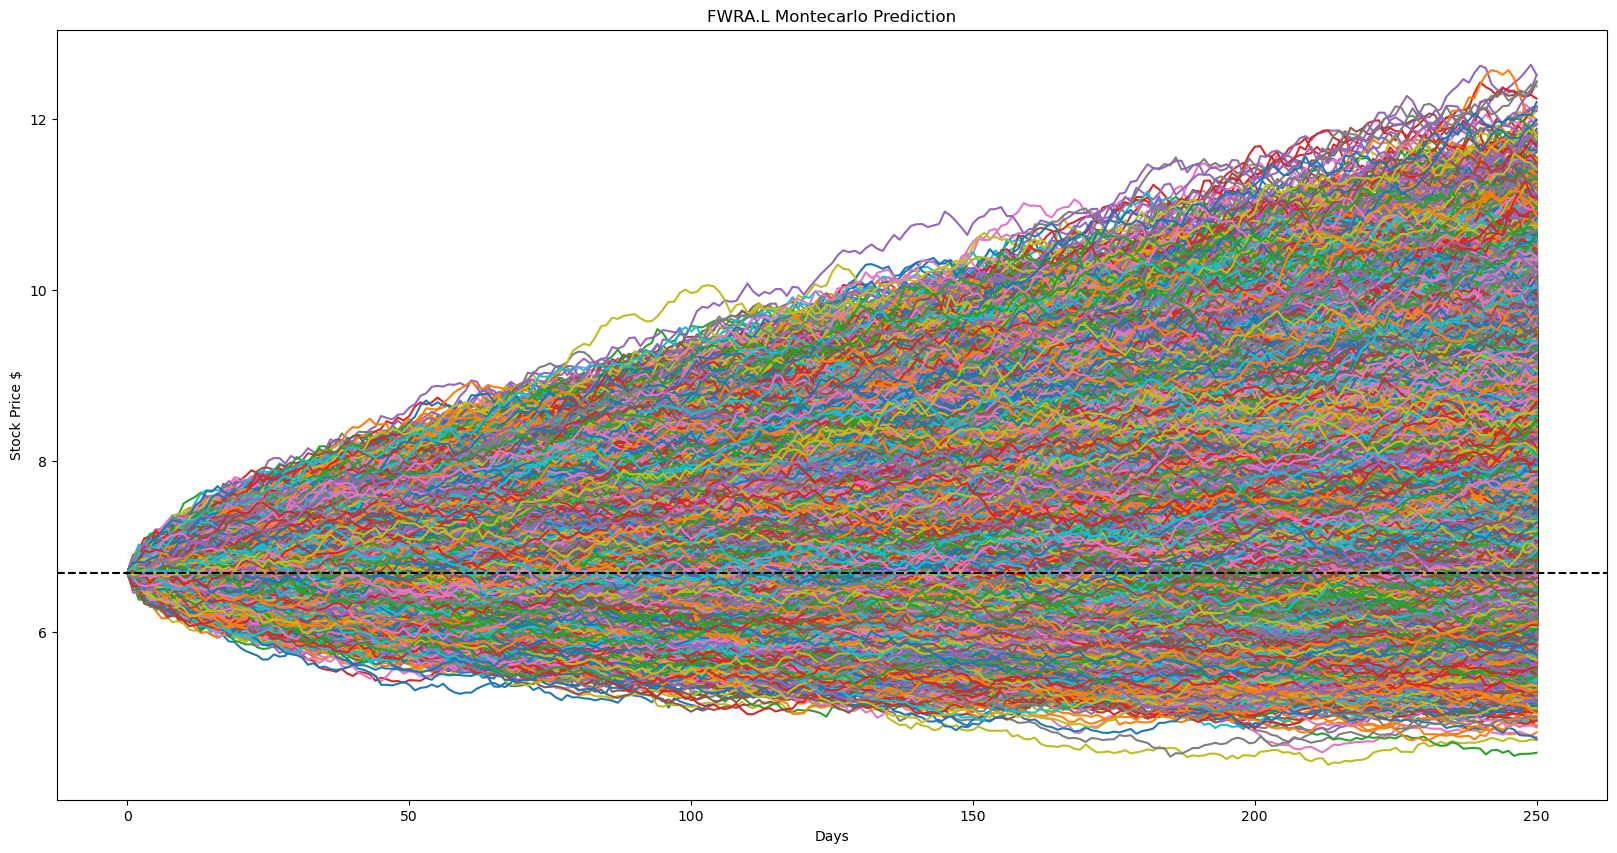

Estimated Average Stock price : 7.210351761380366
Simulations above the estimated average : 485167 , below the estimated average : 514833
Simulations above the last price : 885671 , below the last price : 114329
Estimated Average Gain for 250 days and 1000000 number_simulation is : 7.806490002657325 % 


In [15]:
## Drift and Volatility
## fp = future predictions

number_simulation_fp = 10**6
days_to_predict_fp   = 250

uniform_or_normal = "normal"



if uniform_or_normal == "uniform":
    Z_fp           = np.random.uniform(-1,+1,(days_to_predict_fp,number_simulation_fp))
    est_error_fp   = np.std(logret)/np.sqrt(number_simulation_fp)
else:
    Z_fp           = np.random.normal(0,1,(days_to_predict_fp,number_simulation_fp))
    
    est_error_fp   = 3*np.std(logret)/np.sqrt(number_simulation)


print(f"With {uniform_or_normal} distribution , your error is : {est_error_fp}")

## Array with rows = days_to_predict , columns = number_simulation_fp

## Z_fp           = np.random.normal(0,1,((days_to_predict_fp,number_simulation_fp)))  

# drift       = np.mean(logret) - np.var(logret)/2 --> it is not affected by the number of days to predict

volatility_fp  = np.std(logret) * Z_fp

#volatility_vol_fp = np.std(logvol) * Z_fp

## Just to have exponential daily return as pdDataFrame for further calculations

exponential_daily_logarithmic_return = np.exp(drift+volatility_fp)

#exponential_daily_logarithmic_volume_return = np.exp(drift_vol+volatility_vol_fp)


df_exponential_daily_logarithmic_return = pd.DataFrame(exponential_daily_logarithmic_return)
#df_exponential_daily_logarithmic_volume_return = pd.DataFrame(exponential_daily_logarithmic_volume_return)


## pd.DataFrame for future_prices ---> n_rows = days_to_predict_fp + 1 (because row = 0 is filled with the latest price retrieved from Yahoo Finance) , n_colums = number_simulation_fp

future_prices = pd.DataFrame(np.zeros((days_to_predict_fp+1,number_simulation_fp)))
#future_volumes = pd.DataFrame (np.zeros((days_to_predict_fp+1,number_simulation_fp)))

future_prices.iloc[0]  = stock_prices.iloc[-1] ## Last stock price from Yf
#future_volumes.iloc[0] = stock_volumes.iloc[-1] ## Last Volume from YF

## We implement the formula described at the beginning
# Define a function to compute future prices for a single simulation
def compute_future_prices(simulation_index):
    future_prices_sim = np.zeros(days_to_predict_fp + 1)
    future_prices_sim[0] = stock_prices.iloc[-1]
    for i in range(1, days_to_predict_fp + 1):
        future_prices_sim[i] = future_prices_sim[i - 1] * exponential_daily_logarithmic_return[i - 1, simulation_index]
    return future_prices_sim

# Use joblib to parallelize the computation of future prices
results = Parallel(n_jobs=-1)(delayed(compute_future_prices)(i) for i in range(number_simulation_fp))

# Combine the results into the future_prices DataFrame
for i, result in enumerate(results):
    future_prices.iloc[:, i] = result

# for i in range (1,days_to_predict_fp+1):
#     future_prices.iloc[i] = future_prices.iloc[i-1] * df_exponential_daily_logarithmic_return.iloc[i-1]
    #future_volumes.iloc[i] = future_volumes.iloc[i-1] * df_exponential_daily_logarithmic_volume_return.iloc[i-1]


future_prices.plot(title=f"{stock_under_test} Montecarlo Prediction",ylabel="Stock Price $",xlabel="Days",figsize=(20,10),legend=None)
### To identify where is located Last Price
plt.axhline(y=stock_prices.iloc[-1], color='black', linestyle='--', label='Initial Value')
plt.show()


## 2nd method
## returns     = stock_prices.pct_change()
## logret_pct  = np.log(returns+1)
## mu,sigma    = logret_pct.mean(), logret_pct.std()
## future_prices_2nd_array = pd.DataFrame(np.zeros((number_simulation_fp)))
## for i in range (number_simulation_fp):
##     predicted_returns = np.random.normal(mu,sigma,(days_to_predict_fp))
##     future_prices_2nd = stock_prices.iloc[-1] * ((1+predicted_returns).cumprod())
##     future_prices_2nd_array.iloc[i] = future_prices_2nd
##     ### To identify where is located Last Price
##     plt.axhline(y=stock_prices.iloc[-1], color='black', linestyle='--', label='Initial Value')
##     plt.plot(future_prices_2nd)
## 
## print(f"Estimated Average Stock Price 2nd version: € {future_prices_2nd.mean()}")


#check_difference_future_prices = future_prices - future_prices_2nd

#future_volumes.plot(title=f"{stock_under_test} Montecarlo Volume Prediction",ylabel="Volume",xlabel="Days",figsize=(20,10),legend=None)


#future_prices.plot(kind='hist',bins= 100, title=f"{stock_under_test} Montecarlo Prediction",figsize=(20,10),xlabel="Stock Price",ylabel="Frequency",legend=None)
#future_volumes.plot(kind='hist',bins= 100,title=f"{stock_under_test} Montecarlo Volume Prediction",ylabel="Frequency",xlabel="Volume",figsize=(20,10),legend=None)


# Array that contains the average of each row of future_prices
array_mean_future_prices = future_prices.mean()

# Simulations above the average
sims_above_average = (future_prices.mean() >= array_mean_future_prices.mean()).sum()
# Simulations below the average
sims_below_average = (future_prices.mean() < array_mean_future_prices.mean()).sum()

# Simulations above last price
sims_above_last_price = (future_prices.mean() >= stock_prices.iloc[-1]).sum()
# Simulations below last price
sims_below_last_price = (future_prices.mean() < stock_prices.iloc[-1]).sum()

 

# Comparison respect to the last value of stock_prices
gain_future_prices = ((array_mean_future_prices.mean() - stock_prices.iloc[-1])/(stock_prices.iloc[-1]))*100

print(f"Estimated Average Stock price : {array_mean_future_prices.mean()}")
print(f"Simulations above the estimated average : {sims_above_average} , below the estimated average : {sims_below_average}")
print(f"Simulations above the last price : {sims_above_last_price} , below the last price : {sims_below_last_price}")
print(f"Estimated Average Gain for {days_to_predict_fp} days and {number_simulation_fp} number_simulation is : {gain_future_prices} % ")



In [8]:
import numpy as np

# Inputs
number_simulation = 10**4
weekly_investment = 25
weeks_in_year = 52
bid_reference_price = 9.97
ask_reference_price = 10.05

# Funzione per simulare bid e ask price
def simulate_prices(reference_price, number_simulation, spread=0.08):
    return np.random.normal(0, 1, number_simulation)

# Inizializza costi totali dello spread
total_annual_spread_cost = 0
annual_spread_cost = 0
monthly_spread_cost = 0
quarterly_spread_cost = 0

# Calcolo settimanale
for _ in range(weeks_in_year):
    bid_price = bid_reference_price + simulate_prices(bid_reference_price, 10**3)
    ask_price = ask_reference_price + simulate_prices(ask_reference_price, 10**3)
    if ask_price >= bid_price :
        shares_bought = weekly_investment / ask_price
        total_annual_spread_cost += (ask_price - bid_price) * shares_bought
    else :  
        print("ERROR!: Bid > Ask")

# Calcolo annuale
bid_price = bid_reference_price + simulate_prices(bid_reference_price, 10**3)
ask_price = ask_reference_price + simulate_prices(ask_reference_price, 10**3)
if ask_price >= bid_price :
    shares_bought_annual = (weekly_investment * weeks_in_year) / ask_price
    annual_spread_cost = (ask_price - bid_price) * shares_bought_annual
else :   
        print("ERROR!: Bid > Ask")

# Calcolo mensile
for _ in range(12):
    bid_price = bid_reference_price + simulate_prices(bid_reference_price, 10**3)
    ask_price = ask_reference_price + simulate_prices(ask_reference_price, 10**3)
    if ask_price >= bid_price :
        shares_bought_monthly = (weekly_investment * weeks_in_year / 12) / ask_price
        monthly_spread_cost += (ask_price - bid_price) * shares_bought_monthly
    else :   
        print("ERROR!: Bid > Ask")
# Calcolo trimestrale
for _ in range(4):
    bid_price = bid_reference_price + simulate_prices(bid_reference_price, 10**3)
    ask_price = ask_reference_price + simulate_prices(ask_reference_price, 10**3)
    if ask_price >= bid_price :
        shares_bought_quarterly = (weekly_investment * weeks_in_year / 4) / ask_price
        quarterly_spread_cost += (ask_price - bid_price) * shares_bought_quarterly
    else :   
        print("ERROR!: Bid > Ask")

# Stampa dei risultati

annual_spread_cost.plot(title=f"{stock_under_test} Montecarlo Prediction",ylabel="Stock Price $",xlabel="Days",figsize=(20,10),legend=None)

#print(f"Costo totale dello spread per un anno con investimento settimanale: {total_annual_spread_cost}")
#print(f"Costo dello spread con investimento una tantum annuale: {annual_spread_cost:.2f}")
#print(f"Costo dello spread con investimento mensile: {monthly_spread_cost:.2f}")
#print(f"Costo dello spread con investimento trimestrale: {quarterly_spread_cost:.2f}")


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [6]:
### For the histogram it is needed to calculate the proper value for bins in order to avoid spread of information

Q1 = future_prices.quantile(0.25)
Q3 = future_prices.quantile(0.75)
IQR = Q3 - Q1


# Freedman-Diaconis rule to find the optimal width for the bins
bin_width = 2 * IQR * (len(future_prices) ** (-1/3))
# Number of bins
bins_fd = ((future_prices.max() - future_prices.min()) / bin_width)

# Plotta l'istogramma con il numero di bins calcolato
plt.hist(future_prices, bins=bins_fd, alpha=0.7)
plt.title(f'{stock_under_test} Future Prices')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

NameError: name 'future_prices' is not defined